# Proyek Klasifikasi Gambar : The Simpsons Characters Data

- **Nama:** Akbar Widianto
- **Email:** wdntoakbar@gmail.com
- **ID Dicoding:** wakbarr

## Import semua pakage / Library yang digunakan

In [2]:
import os
import zipfile
import gdown
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter
import tensorflowjs as tfjs

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
# Konfigurasi akses ke Kaggle untuk mengunduh dataset
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Persiapan direktori untuk dataset
dataset_dir = "simpsons_dataset"
os.makedirs(dataset_dir, exist_ok=True)

In [5]:
# Unduh dan ekstrak dataset dari Kaggle
os.system(f"kaggle datasets download -d alexattia/the-simpsons-characters-dataset --unzip -p {dataset_dir}")

0

In [6]:
# Path ke dataset asli
data_path = os.path.join(dataset_dir, 'simpsons_dataset')

In [7]:
# Hitung jumlah gambar per kelas dan pilih 3 kelas teratas
class_counts = Counter([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
top_3_classes = [cls for cls, count in class_counts.most_common(3)]

In [8]:
print(os.listdir('./simpsons_dataset'))

['number_pic_char.csv', 'weights.best.hdf5', 'simpsons_dataset', 'characters_illustration.png', 'annotation.txt', 'kaggle_simpson_testset']


In [9]:
# Filter dataset untuk hanya 3 kelas teratas
filtered_data_path = 'simpsons_dataset_filtered'
os.makedirs(filtered_data_path, exist_ok=True)

for cls in top_3_classes:
    src_dir = os.path.join(data_path, cls)
    dst_dir = os.path.join(filtered_data_path, cls)
    os.makedirs(dst_dir, exist_ok=True)
    for img in os.listdir(src_dir):
        src = os.path.abspath(os.path.join(src_dir, img))
        dst = os.path.join(dst_dir, img)
        if not os.path.exists(dst):
            # Anda dapat gunakan symlink atau copy
            try:
                os.symlink(src, dst)
            except OSError:
                shutil.copy(src, dst)

In [10]:
# Cek satu contoh symlink/file
sample_path = os.path.join(filtered_data_path, top_3_classes[0], os.listdir(os.path.join(filtered_data_path, top_3_classes[0]))[0])
print(f"Sample file exists: {os.path.exists(sample_path)} (symlink: {os.path.islink(sample_path)})")


Sample file exists: True (symlink: True)


In [11]:
# Inisialisasi ImageDataGenerator untuk augmentasi dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Siapkan generator untuk train, validation, dan test
generator_params = dict(
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    seed=42
)

train_generator = train_datagen.flow_from_directory(
    filtered_data_path,
    subset='training',
    **generator_params
)

val_generator = train_datagen.flow_from_directory(
    filtered_data_path,
    subset='validation',
    **generator_params
)

test_generator = test_datagen.flow_from_directory(
    filtered_data_path,
    shuffle=False,
    **generator_params
)

Found 1195 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 1492 images belonging to 3 classes.


In [13]:
# Definisi arsitektur model Sequential
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks untuk optimasi pelatihan
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_simpsons_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [15]:
# Pelatihan model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 485ms/step - accuracy: 0.9252 - loss: 0.2772 - val_accuracy: 0.1313 - val_loss: 0.9632 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.9691 - loss: 0.1338 - val_accuracy: 0.9764 - val_loss: 0.4670 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9744 - loss: 0.0953 - val_accuracy: 0.9764 - val_loss: 0.2803 - learning_rate: 1.0000e-04
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.9738 - loss: 0.0977 - val_accuracy: 0.9764 - val_loss: 0.2988 - learning_rate: 1.0000e-04
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9881 - loss: 0.0530 - val_accuracy: 0.9764 - val_loss: 0.2349 - learning_rate: 1.0000e-04
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9869 - loss: 0.0596 - val_accuracy: 0.9764 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accu

In [16]:
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi pada Test Set: {test_accuracy:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9757 - loss: 0.1205
Akurasi pada Test Set: 0.9732


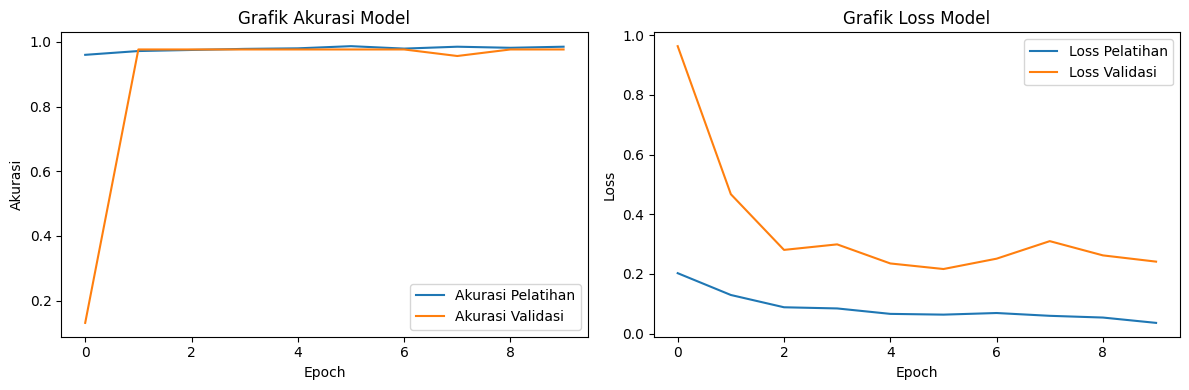

In [17]:
# Visualisasi akurasi dan loss
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Grafik Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')

In [18]:
# Simpan model dalam berbagai format
model.save('simpsons_model.keras')
model.export('saved_model_simpsons')

Saved artifact at 'saved_model_simpsons'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136920620887568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920620885840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621156304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621156112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621155152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621160528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621160912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369206211

In [19]:
# Buat direktori TF-Lite jika belum ada
os.makedirs('tflite', exist_ok=True)


In [20]:
# Konversi dan simpan TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
with open('tflite/simpsons_model.tflite', 'wb') as f:
    f.write(converter.convert())

Saved artifact at '/tmp/tmpp8hle250'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136920620887568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920620885840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621156304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621156112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621155152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621160528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621160912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136920621159376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13692062116072

In [21]:
# Simpan label kelas
tf_lite_labels_path = os.path.join('tflite', 'labels.txt')
with open(tf_lite_labels_path, 'w') as f:
    f.write("\n".join(list(train_generator.class_indices.keys())))

In [22]:
# Simpan untuk TFJS
tfjs.converters.save_keras_model(model, 'tfjs_simpsons_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [23]:
# Buat requirements.txt
with open('requirements.txt', 'w') as f:
    f.write("tensorflow==2.18.0\n")
    f.write("tensorflowjs==4.22.0\n")
    f.write("matplotlib==3.9.2\n")
    f.write("numpy==1.26.4\n")
